# **Chapter 14**
## *Outlier Detection Using Unsupervised Machine Learning*, 

This chapter continues from **Chapter 8**, *Outlier Detection Using Statistical Methods*, but focuses on more advanced **unsupervised machine learning** methods. You will use the same datasets from the NAB to allow you to compare statistical and machine learning techniques using the same benchmark data. The techniques cover a variety of machine learning algorithms.


You will be using the same New York taxi dataset to make it easier to compare the results between the different machine learning methods in this chapter and the statistical methods from **Chapter 8**, *Outlier Detection Using Statistical Methods*.  


# -- START: Techical Requirements --

You can install PyOD with either `pip` or `conda`. 

* For a pip install, run the following command:

```
pip install pyod
```


* For a `conda` install, run the following command:

```
conda install -c conda-forge pyod
```

In [1]:
import matplotlib 
import pandas as pd
import pyod 
import statsmodels

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
''')


Matplotlib -> 3.10.6
pandas -> 2.3.3   



In [2]:
from pyod import version
version.__version__

'2.0.6'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from utils import plot_outliers

plt.rcParams["figure.figsize"] = [12, 5]

In [4]:
# ###### configurations for image quality#######
# plt.rcParams["figure.figsize"] = [12, 5]   ##
# # plt.rcParams['figure.dpi'] = 300           ## 300 for printing
# plt.rc('font', size=8)                     ## 
# plt.rc('axes', titlesize=16)               ## 
# plt.rc('axes', labelsize=14)               ##
# plt.rc('xtick', labelsize=10)              ##
# plt.rc('ytick', labelsize=10)              ##
# plt.rc('legend', fontsize=10)              ##
# plt.rc('figure', titlesize=12)             ## 
# #############################################

### Create DataFrames 

In [5]:
file = Path("../../datasets/Ch14/nyc_taxi.csv")
nyc_taxi = pd.read_csv(file, 
                     index_col='timestamp', 
                     parse_dates=True)
nyc_taxi.index.freq = '30min'

### Visualize DataFrames

In [6]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq='30min')

In [7]:
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]
tx = nyc_taxi.resample('D').mean()
known_outliers = tx.loc[nyc_dates]

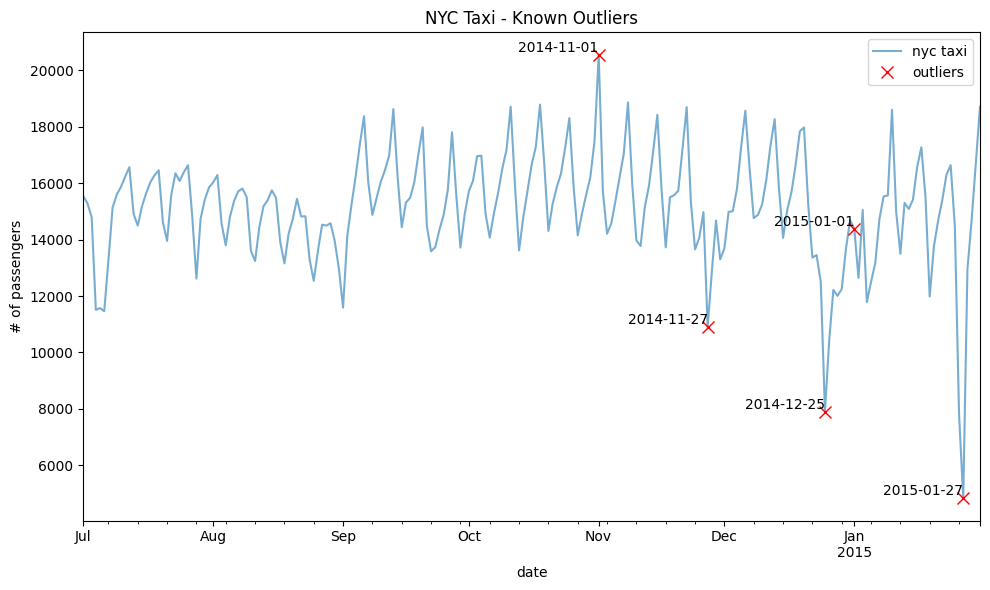

In [8]:
plot_outliers(known_outliers, tx, 'Known Outliers', labels=True)

In [10]:
def create_sliding_windows(df, window_size):
    """Transform time series data into sliding windows for anomaly detection.
    
    Creates a DataFrame where each row represents a sliding window of observations,
    allowing anomaly detection algorithms to identify unusual temporal patterns.
    
    Args:
        df (pd.DataFrame): Univariate time series data with values in a single column
        window_size (int): Number of time steps in each sliding window
        
    Returns:
        pd.DataFrame: DataFrame where each row is a complete window of observations,
                     and columns represent the position within the window
    """
    # Validate input
    if not isinstance(window_size, int) or window_size < 1:
        raise ValueError("Window size must be a positive integer")
    
    # Convert DataFrame to 1D array
    d = df.values.squeeze()
    
    # Create sliding windows using numpy's efficient implementation
    windows = np.lib.stride_tricks.sliding_window_view(d, window_shape=window_size)[:-1]
    
    # Create column names for positions within the window
    cols = [f'pos_{i}' for i in range(window_size)]
    
    # Create DataFrame with windows
    windows_df = pd.DataFrame(windows, columns=cols, index=df.index[window_size:])
    
    return windows_df

In [11]:
import holidays

def add_time_features(df):
    """Add time-based and exogenous features to a daily time series dataset.
    
    Creates features useful for time series anomaly detection by encoding 
    temporal patterns and external factors that might influence the data.
    
    Args:
        df (pd.DataFrame): Time series DataFrame with DatetimeIndex
        
    Returns:
        pd.DataFrame: Original DataFrame with additional time-based features
    """
    # Create a copy to avoid modifying the original
    result = df.copy()
    
    # Cyclical encoding for day of week (weekly seasonality)
    result['dow_sin'] = np.sin(2 * np.pi * result.index.dayofweek / 7)
    result['dow_cos'] = np.cos(2 * np.pi * result.index.dayofweek / 7)
    
    # Cyclical encoding for month (yearly seasonality)
    result['month_sin'] = np.sin(2 * np.pi * result.index.month / 12)
    result['month_cos'] = np.cos(2 * np.pi * result.index.month / 12)
    
    # Keep year for trend analysis
    result['year'] = result.index.year
    
    # Trend feature (simple incremental counter)
    result['time'] = np.arange(1, len(result)+1)
    
    # US holidays - fix the datetime comparison warning
    us_holidays = holidays.US(years=result.index.year.unique())
    result['is_holiday'] = result.index.map(lambda x: x in us_holidays).astype(int)
    
    # Weekend feature
    result['is_weekend'] = (result.index.dayofweek >= 5).astype(int)
    
    # Month start/end features (can be important for taxi data)
    result['is_month_start'] = result.index.is_month_start.astype(int)
    result['is_month_end'] = result.index.is_month_end.astype(int)
    
    # For NYC taxi data: check if it's a typical commuting day
    result['is_commuting_day'] = ((~result['is_holiday'].astype(bool)) & 
                                 (~result['is_weekend'].astype(bool))).astype(int)
    
    return result

In [12]:
create_sliding_windows(tx, 2)

,pos_0,pos_1
timestamp,,
2014-07-03,15540.979167,15284.166667
2014-07-04,15284.166667,14794.625000
2014-07-05,14794.625000,11511.770833
2014-07-06,11511.770833,11572.291667
2014-07-07,11572.291667,11464.270833
...,...,...
2015-01-27,14463.791667,7818.979167
2015-01-28,7818.979167,4834.541667
2015-01-29,4834.541667,12947.562500


In [13]:
add_time_features(tx)

,value,dow_sin,dow_cos,month_sin,month_cos,year,time,is_holiday,is_weekend,is_month_start,is_month_end,is_commuting_day
timestamp,,,,,,,,,,,,
2014-07-01,15540.979167,0.781831,0.623490,-0.5,-0.866025,2014,1,0,0,1,0,1
2014-07-02,15284.166667,0.974928,-0.222521,-0.5,-0.866025,2014,2,0,0,0,0,1
2014-07-03,14794.625000,0.433884,-0.900969,-0.5,-0.866025,2014,3,0,0,0,0,1
2014-07-04,11511.770833,-0.433884,-0.900969,-0.5,-0.866025,2014,4,1,0,0,0,0
2014-07-05,11572.291667,-0.974928,-0.222521,-0.5,-0.866025,2014,5,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-27,4834.541667,0.781831,0.623490,0.5,0.866025,2015,211,0,0,0,0,1
2015-01-28,12947.562500,0.974928,-0.222521,0.5,0.866025,2015,212,0,0,0,0,1
2015-01-29,14686.145833,0.433884,-0.900969,0.5,0.866025,2015,213,0,0,0,0,1


# Detecting outliers using statistical & distance-based algorithms (PyOD)

In [14]:
from pyod.models.knn import KNN
from pyod.models.lof import LOF

## Detecting Point Outliers

In [15]:
knn = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)
print(knn)

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)


In [16]:
lof = LOF(contamination=0.03, 
          n_neighbors=20) 
print(lof)

LOF(algorithm='auto', contamination=0.03, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2)


In [17]:
knn.fit(tx)
lof.fit(tx)

,n_neighbors,20
,algorithm,'auto'
,leaf_size,30
,metric,'minkowski'
,p,2
,metric_params,None
,contamination,0.03
,n_jobs,1
,novelty,True


In [18]:
knn_pred = pd.Series(knn.predict(tx), 
                      index=tx.index)

lof_pred = pd.Series(lof.predict(tx), 
                      index=tx.index)

In [19]:
print('Number of KNN outliers = ', knn_pred.sum())
print('Number of LOF outliers = ', lof_pred.sum())

Number of KNN outliers =  6
Number of LOF outliers =  6


In [20]:
# known outliers dates
print(tx.loc[nyc_dates])

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667


In [22]:
# extract the outlier values and dates from knn_pred
knn_outliers = knn_pred[knn_pred == 1]
knn_outliers = tx.loc[knn_outliers.index] 
print(knn_outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


In [23]:
# extract the outlier values and dates from lof_pred
lof_outliers = lof_pred[lof_pred == 1]
lof_outliers = tx.loc[lof_outliers.index] 
print(lof_outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


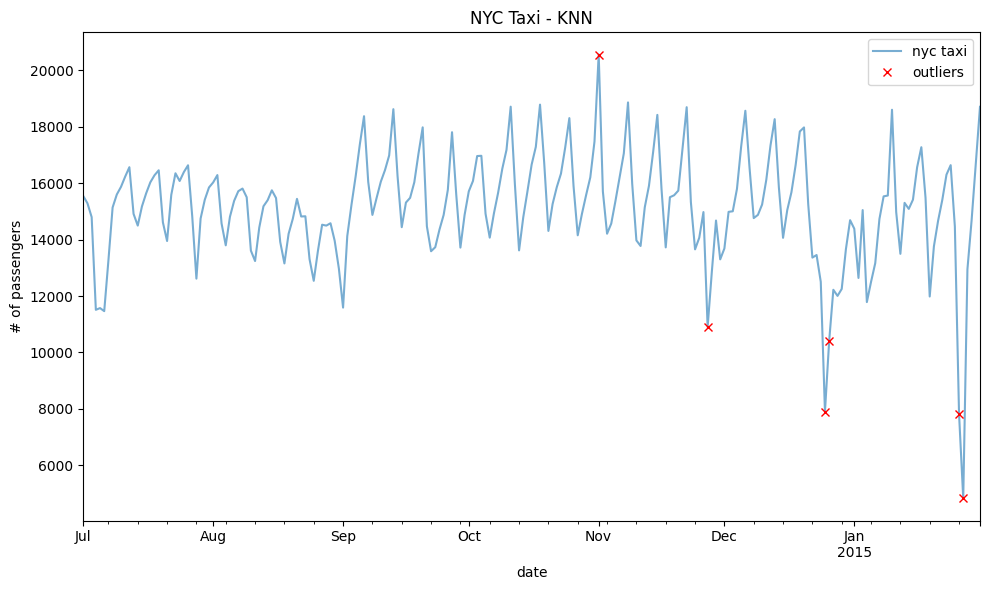

In [24]:
plot_outliers(knn_outliers, tx, 'KNN')

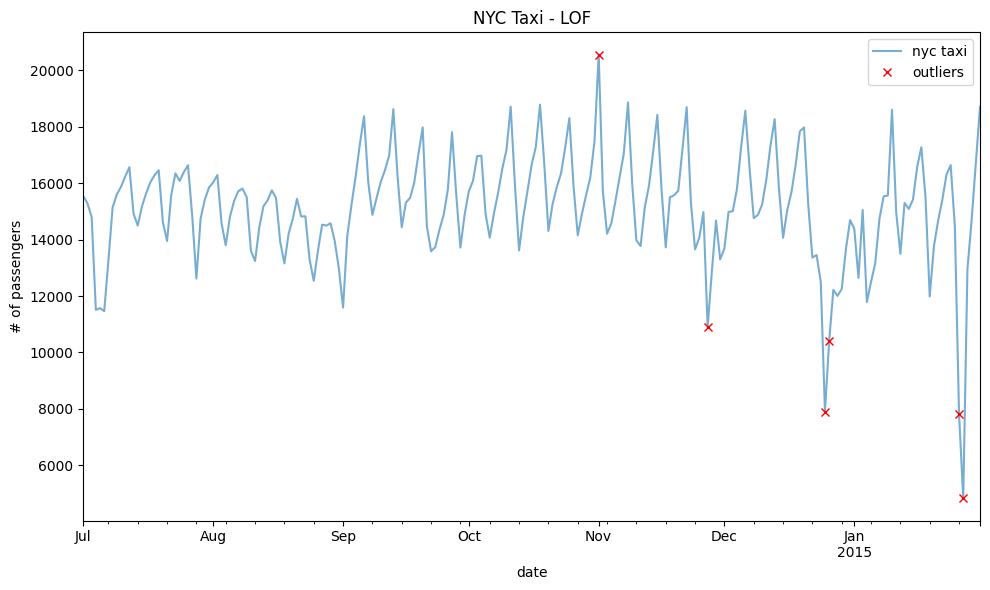

In [25]:
plot_outliers(lof_outliers, tx, 'LOF')

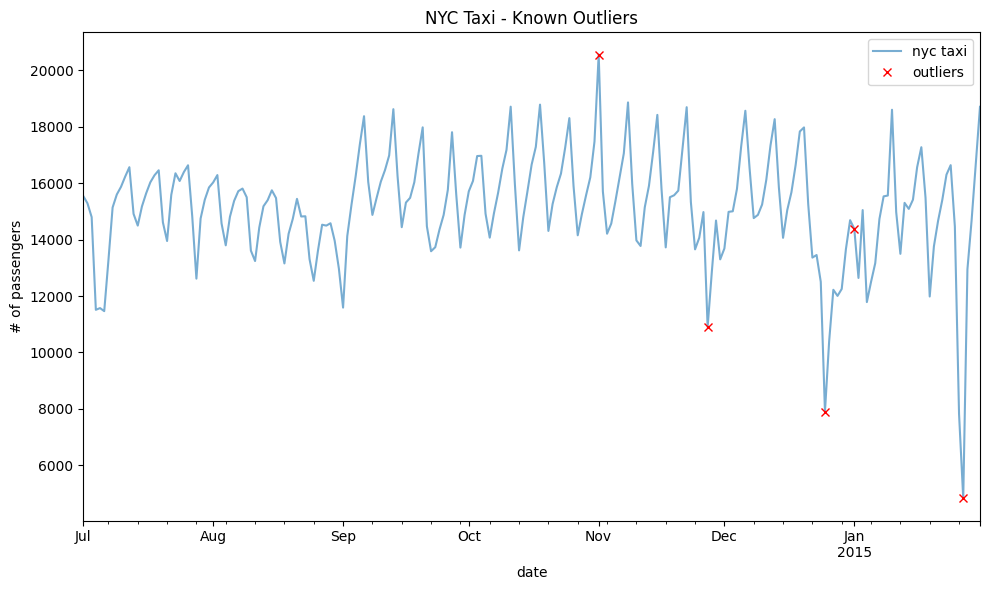

In [26]:
plot_outliers(known_outliers, tx, 'Known Outliers')

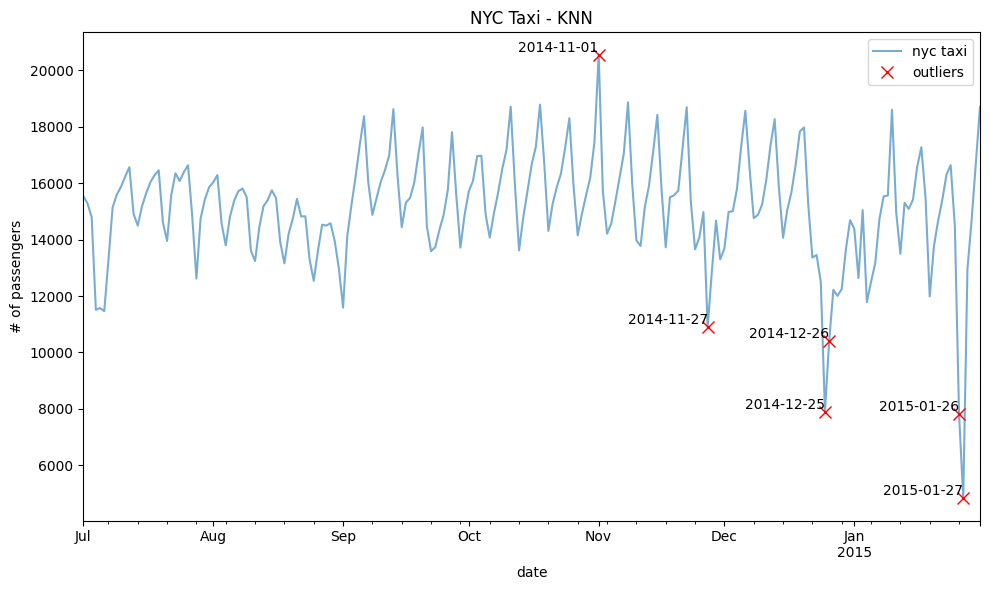

In [27]:
plot_outliers(knn_outliers, 
              tx, 
              'KNN',
              labels=True)

## Detecting Outliers after Decomposition

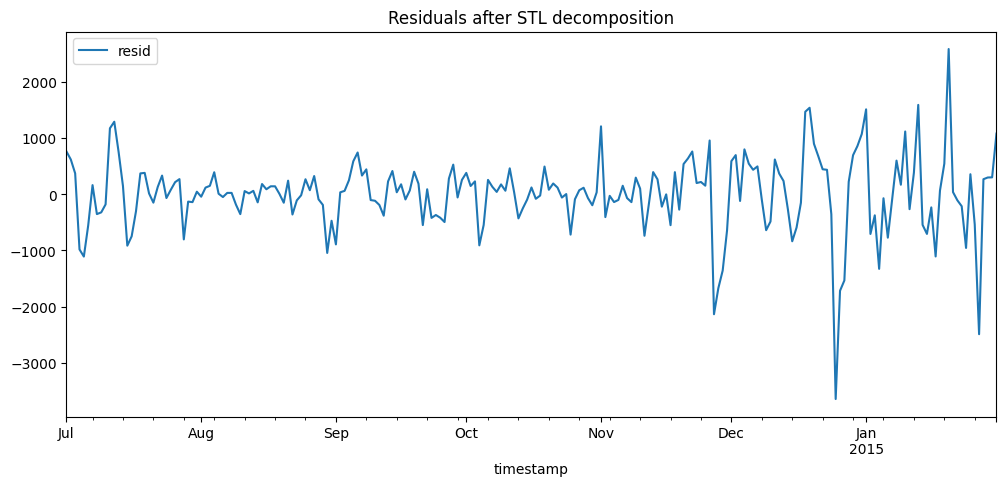

In [28]:
from statsmodels.tsa.seasonal import STL

# For daily data with weekly seasonality
stl = STL(tx, seasonal=7)
result = stl.fit()
residuals = result.resid.dropna().to_frame()

residuals.plot(title='Residuals after STL decomposition');




In [29]:
knn_decomp = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)
lof_decomp = LOF(contamination=0.03, 
          n_neighbors=20) 

# Apply PyOD to residuals
knn_r = knn_decomp.fit(residuals)
lof_r = lof_decomp.fit(residuals)

knn_pred_r = pd.Series(knn_decomp.predict(residuals), 
                      index=residuals.index)

lof_pred_r = pd.Series(lof_decomp.predict(residuals), 
                      index=residuals.index)

In [30]:
print('Number of KNN outliers after Decomposition = ', knn_pred_r.sum())
print('Number of LOF outliers  after Decomposition = ', lof_pred_r.sum())

Number of KNN outliers after Decomposition =  4
Number of LOF outliers  after Decomposition =  4


In [31]:
print(known_outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667


In [32]:
# extract the outlier values and dates from knn_pred_r
knn_outliers_r = knn_pred_r[knn_pred_r == 1]
knn_outliers_r = tx.loc[knn_outliers_r.index] 
print(knn_outliers_r)

                   value
timestamp               
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-20  13759.416667
2015-01-27   4834.541667


In [33]:
# extract the outlier values and dates from lof_pred_r
lof_outliers_r = lof_pred_r[lof_pred_r == 1]
lof_outliers_r = tx.loc[lof_outliers_r.index] 
print(lof_outliers_r)

                   value
timestamp               
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-20  13759.416667
2015-01-27   4834.541667


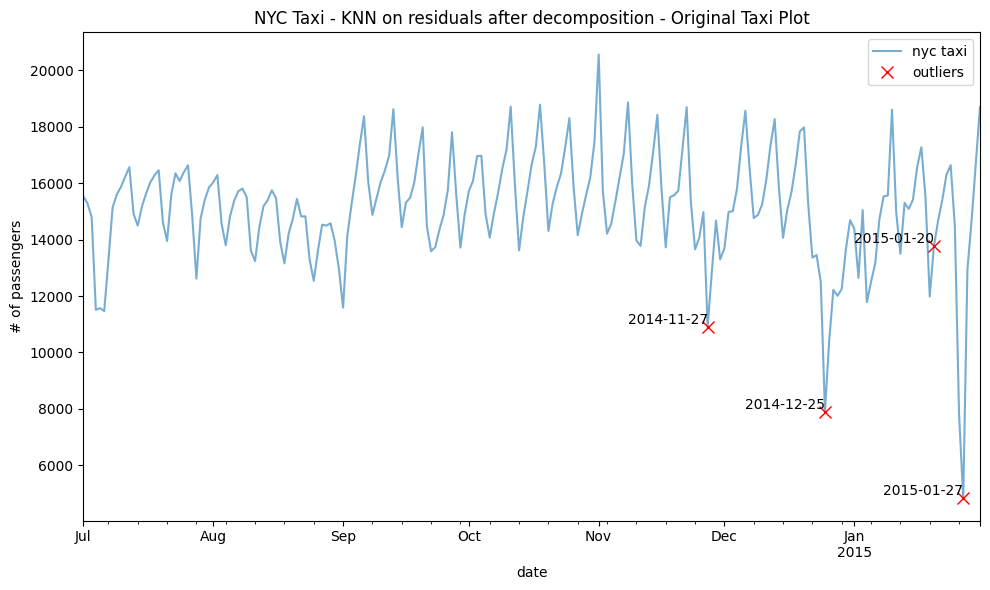

In [34]:
plot_outliers(knn_outliers_r, tx, 'KNN on residuals after decomposition - Original Taxi Plot', labels=True)

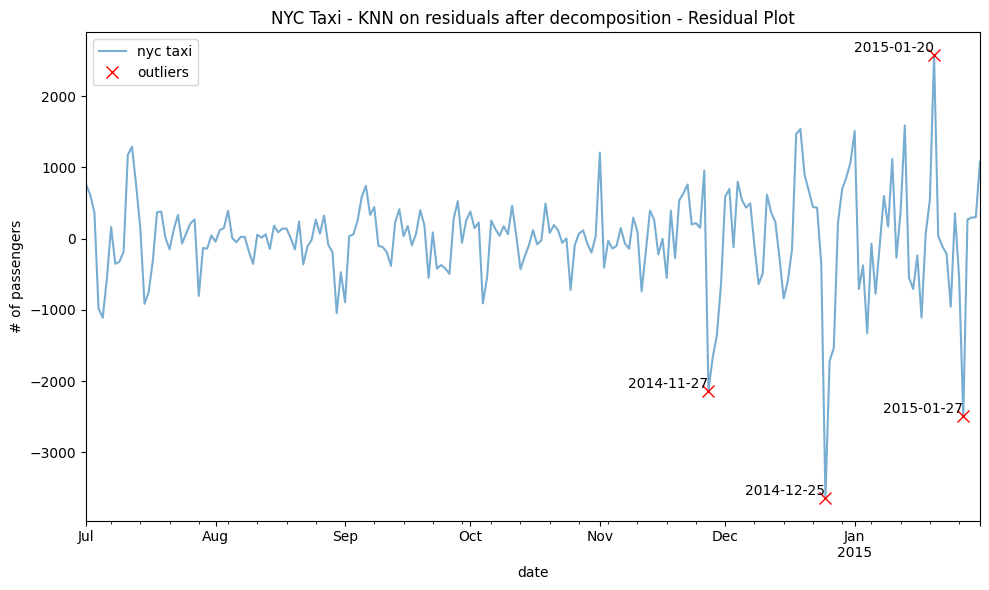

In [35]:
res = residuals[knn_pred_r == 1]
res.columns = ['value']
plot_outliers(res, residuals, 'KNN on residuals after decomposition - Residual Plot', labels=True)

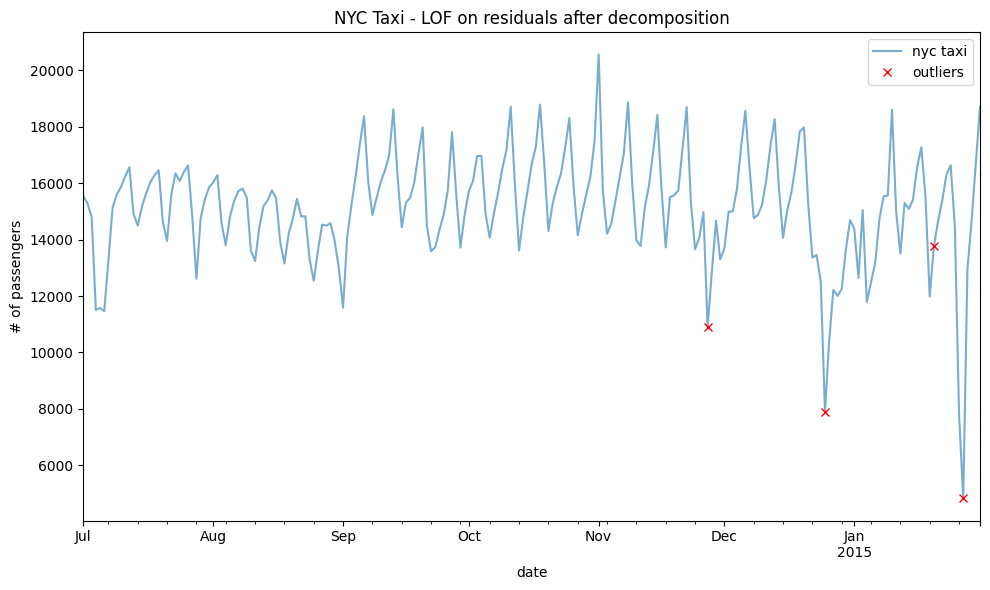

In [36]:
plot_outliers(lof_outliers_r, tx, 'LOF on residuals after decomposition')

## Detecting Contextual Outliers with Sliding Window

In [37]:
def create_sliding_windows(df, window_size):
    """Transform time series data into sliding windows for anomaly detection.
    
    Creates a DataFrame where each row represents a sliding window of observations,
    allowing anomaly detection algorithms to identify unusual temporal patterns.
    
    Args:
        df (pd.DataFrame): Univariate time series data with values in a single column
        window_size (int): Number of time steps in each sliding window
        
    Returns:
        pd.DataFrame: DataFrame where each row is a complete window of observations,
                     and columns represent the position within the window
    """
    # Validate input
    if not isinstance(window_size, int) or window_size < 1:
        raise ValueError("Window size must be a positive integer")
    
    # Convert DataFrame to 1D array
    d = df.values.squeeze()
    
    # Create sliding windows using numpy's efficient implementation
    windows = np.lib.stride_tricks.sliding_window_view(d, window_shape=window_size)[:-1]
    
    # Create column names for positions within the window
    cols = [f'pos_{i}' for i in range(window_size)]
    
    # Create DataFrame with windows
    windows_df = pd.DataFrame(windows, columns=cols, index=df.index[window_size:])
    
    return windows_df


In [38]:
tx_sw = create_sliding_windows(tx, window_size=7)
print(tx_sw.shape)

(208, 7)


In [39]:
knn_sw = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)

lof_sw = LOF(contamination=0.03, 
          n_neighbors=20)


knn_sw.fit(tx_sw)
lof_sw.fit(tx_sw)

knn_pred_sw = pd.Series(knn_sw.predict(tx_sw), 
                      index=tx_sw.index)

lof_pred_sw = pd.Series(lof_sw.predict(tx_sw), 
                      index=tx_sw.index)

print('Number of KNN outliers = ', knn_pred_sw.sum())
print('Number of LOF outliers = ', lof_pred_sw.sum())


Number of KNN outliers =  4
Number of LOF outliers =  6


In [40]:
# known outliers dates
print(tx.loc[nyc_dates])

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667


In [41]:
knn_pred_sw

timestamp
2014-07-08    0
2014-07-09    0
2014-07-10    0
2014-07-11    0
2014-07-12    0
             ..
2015-01-27    0
2015-01-28    1
2015-01-29    1
2015-01-30    1
2015-01-31    1
Freq: D, Length: 208, dtype: int64

In [42]:
# extract the outlier values and dates from knn_pred_sw
knn_outliers_sw = knn_pred_sw[knn_pred_sw == 1]
knn_outliers_sw = tx.loc[knn_outliers_sw.index] 
print(knn_outliers_sw)


                   value
timestamp               
2015-01-28  12947.562500
2015-01-29  14686.145833
2015-01-30  16676.625000
2015-01-31  18702.479167


In [43]:
# extract the outlier values and dates from lof_pred_sw
lof_outliers_sw = lof_pred_sw[lof_pred_sw == 1]
lof_outliers_sw = tx.loc[lof_outliers_sw.index] 
print(lof_outliers_sw)


                   value
timestamp               
2014-12-26  10397.958333
2015-01-27   4834.541667
2015-01-28  12947.562500
2015-01-29  14686.145833
2015-01-30  16676.625000
2015-01-31  18702.479167


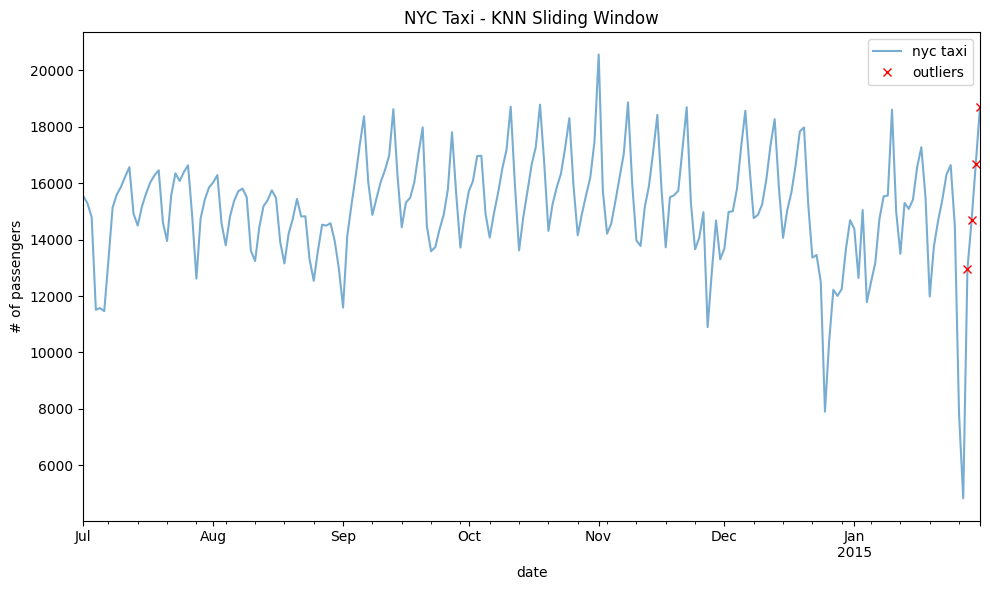

In [44]:
plot_outliers(knn_outliers_sw, tx, 'KNN Sliding Window')

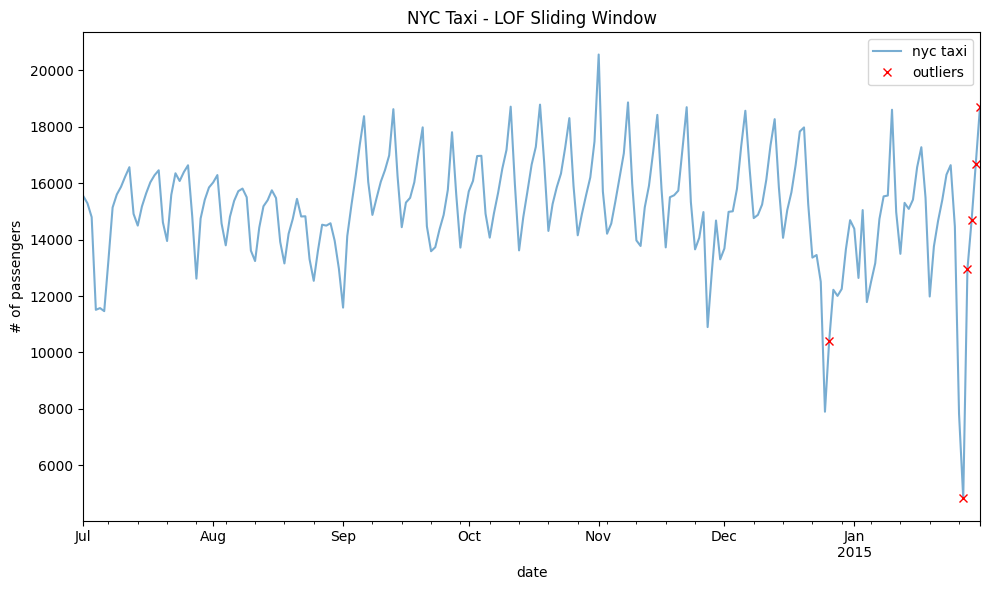

In [45]:
plot_outliers(lof_outliers_sw, tx, 'LOF Sliding Window')

## Detecting Contextual Outliers with Feature Engineering

In [46]:
import holidays

def add_time_features(df):
    """Add time-based and exogenous features to a daily time series dataset.
    
    Creates features useful for time series anomaly detection by encoding 
    temporal patterns and external factors that might influence the data.
    
    Args:
        df (pd.DataFrame): Time series DataFrame with DatetimeIndex
        
    Returns:
        pd.DataFrame: Original DataFrame with additional time-based features
    """
    # Create a copy to avoid modifying the original
    result = df.copy()
    
    # Cyclical encoding for day of week (weekly seasonality)
    result['dow_sin'] = np.sin(2 * np.pi * result.index.dayofweek / 7)
    result['dow_cos'] = np.cos(2 * np.pi * result.index.dayofweek / 7)
    
    # Cyclical encoding for month (yearly seasonality)
    result['month_sin'] = np.sin(2 * np.pi * result.index.month / 12)
    result['month_cos'] = np.cos(2 * np.pi * result.index.month / 12)
    
    # Keep year for trend analysis
    result['year'] = result.index.year
    
    # Trend feature (simple incremental counter)
    result['time'] = np.arange(1, len(result)+1)
    
    # US holidays - fix the datetime comparison warning
    us_holidays = holidays.US(years=result.index.year.unique())
    result['is_holiday'] = result.index.map(lambda x: x in us_holidays).astype(int)
    
    # Weekend feature
    result['is_weekend'] = (result.index.dayofweek >= 5).astype(int)
    
    # Month start/end features (can be important for taxi data)
    result['is_month_start'] = result.index.is_month_start.astype(int)
    result['is_month_end'] = result.index.is_month_end.astype(int)
    
    # For NYC taxi data: check if it's a typical commuting day
    result['is_commuting_day'] = ((~result['is_holiday'].astype(bool)) & 
                                 (~result['is_weekend'].astype(bool))).astype(int)
    
    return result 


In [47]:
# combine with sliding windows for more context
windows = create_sliding_windows(tx, 7)
features = add_time_features(tx)
# Join the windows with the features at the corresponding dates
combined = pd.merge(
    windows, 
    features.drop(columns=['value']),  # Exclude the target value
    left_index=True, 
    right_index=True
)

print(combined.shape)

(208, 18)


In [48]:
knn_fe = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)

lof_fe = LOF(contamination=0.03, 
          n_neighbors=20)


knn_fe.fit(combined)
lof_fe.fit(combined)

knn_pred_fe = pd.Series(knn_fe.predict(combined), 
                      index=combined.index)

lof_pred_fe = pd.Series(lof_fe.predict(combined), 
                      index=combined.index)

# extract the outlier values and dates from knn_pred_fe
knn_outliers_fe = knn_pred_fe[knn_pred_fe == 1]
knn_outliers_fe = tx.loc[knn_outliers_fe.index] 
print(knn_outliers_fe)

                   value
timestamp               
2015-01-28  12947.562500
2015-01-29  14686.145833
2015-01-30  16676.625000
2015-01-31  18702.479167


In [49]:
# extract the outlier values and dates from lof_pred_fe
lof_outliers_fe = lof_pred_fe[lof_pred_fe == 1]
lof_outliers_fe = tx.loc[lof_outliers_fe.index] 
print(lof_outliers_fe)

                   value
timestamp               
2014-12-26  10397.958333
2015-01-27   4834.541667
2015-01-28  12947.562500
2015-01-29  14686.145833
2015-01-30  16676.625000
2015-01-31  18702.479167


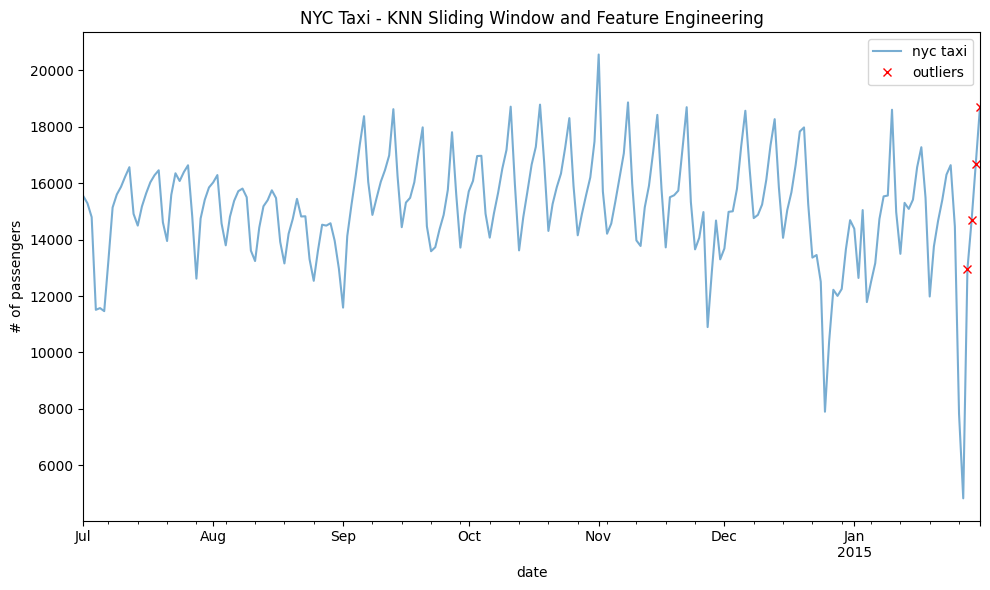

In [50]:
plot_outliers(knn_outliers_fe, tx, 'KNN Sliding Window and Feature Engineering')

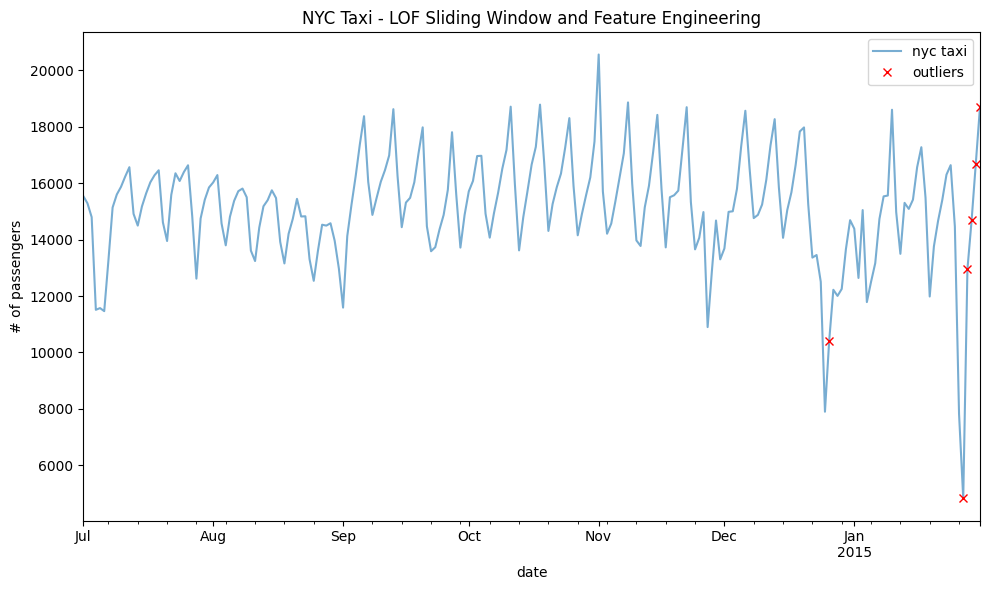

In [51]:
plot_outliers(lof_outliers_fe, tx, 'LOF Sliding Window and Feature Engineering')

## Detecting Contextual Outliers with PyODAdapter

In [52]:
from aeon.anomaly_detection.series import PyODAdapter

In [53]:
knn_aeon = PyODAdapter(
    KNN(contamination=0.03,
        method='mean',
        n_neighbors=5),        
                window_size=7,
                stride=1)

lof_aeon  = PyODAdapter(        
    LOF(contamination=0.03, 
        n_neighbors=20),
                window_size=7,
                stride=1)


knn_pred_aeon = pd.Series(knn_aeon.fit_predict(tx, axis=0), 
                      index=tx.index)

lof_pred_aeon = pd.Series(lof_aeon.fit_predict(tx, axis=0), 
                      index=tx.index)


In [54]:
threshold_knn = knn_pred_aeon.quantile(0.97)  # Top 3% as outliers
threshold_lof = lof_pred_aeon.quantile(0.97)  # Top 3% as outliers

# Create binary labels
knn_outliers_aeon = knn_pred_aeon > threshold_knn
lof_outliers_aeon = lof_pred_aeon > threshold_lof

In [56]:
knn_outliers_aeon_tx = tx[knn_outliers_aeon]
print(knn_outliers_aeon_tx)

                   value
timestamp               
2015-01-25  14463.791667
2015-01-26   7818.979167
2015-01-27   4834.541667
2015-01-28  12947.562500
2015-01-29  14686.145833
2015-01-30  16676.625000
2015-01-31  18702.479167


In [57]:
lof_outliers_aeon_tx = tx[lof_outliers_aeon]
print(lof_outliers_aeon_tx)

                   value
timestamp               
2015-01-25  14463.791667
2015-01-26   7818.979167
2015-01-27   4834.541667
2015-01-28  12947.562500
2015-01-29  14686.145833
2015-01-30  16676.625000
2015-01-31  18702.479167


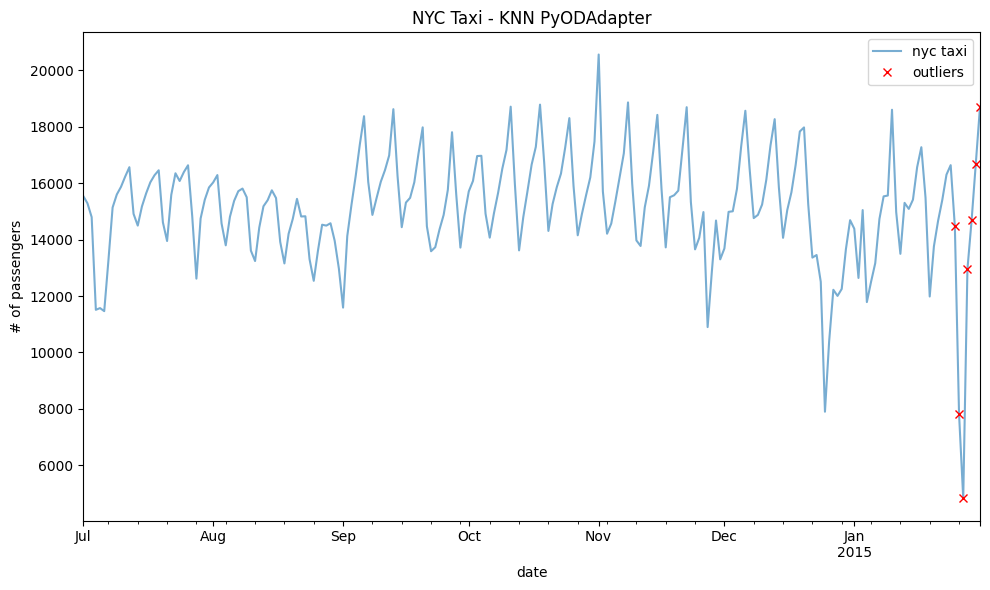

In [59]:
plot_outliers(knn_outliers_aeon_tx, tx, 'KNN PyODAdapter')

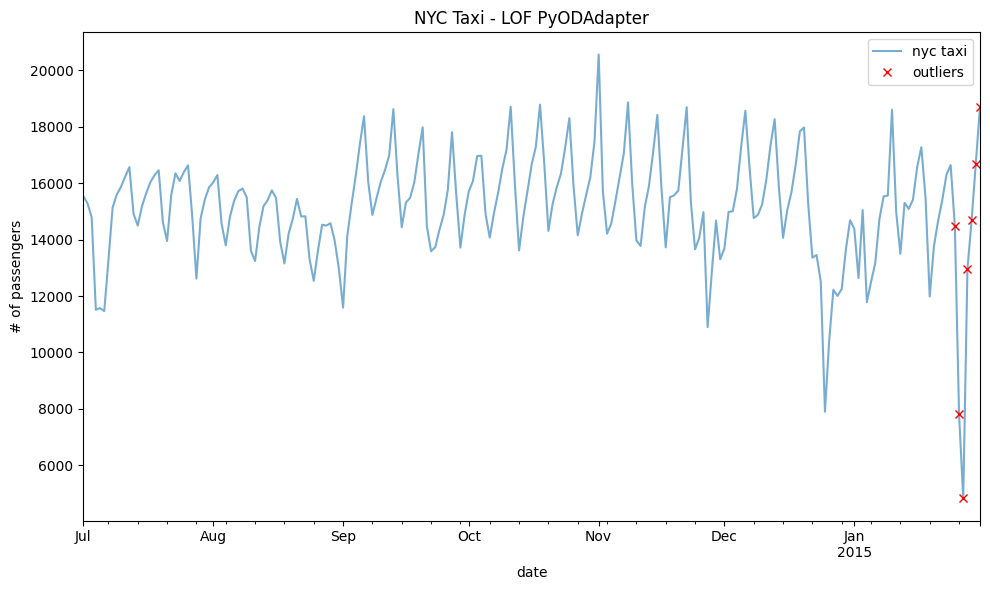

In [60]:
plot_outliers(lof_outliers_aeon_tx, tx, 'LOF PyODAdapter')

## How it works

In [62]:
knn = KNN(contamination=0.03,
          method='mean',
          n_neighbors=5)

knn.fit(tx)

,contamination,0.03
,n_neighbors,5
,method,'mean'
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'minkowski'
,p,2
,metric_params,None
,n_jobs,1


In [63]:
knn_scores = knn.decision_scores_

In [64]:
knn_scores_df = (pd.DataFrame(knn_scores, 
             index=tx.index, 
             columns=['score']))

knn_scores_df.quantile(0.97)

score    225.017917
Name: 0.97, dtype: float64

In [66]:
knn_scores = knn.decision_function(tx)
knn_scores_df = (pd.DataFrame(knn_scores, 
             index=tx.index, 
             columns=['score']))
knn_scores_df.quantile(0.97)

score    161.19375
Name: 0.97, dtype: float64

In [67]:
knn.threshold_

np.float64(225.0179166666657)

In [69]:
print(knn_scores_df[knn_scores_df['score'] > knn.threshold_])

                  score
timestamp              
2014-11-01  1433.762500
2014-11-27   470.208333
2014-12-25  1728.820833
2014-12-26   771.233333
2015-01-26  1745.450000
2015-01-27  3536.112500


In [70]:
n = int(len(tx)*0.03)
print(knn_scores_df.nlargest(n, 'score').sort_index())

                  score
timestamp              
2014-11-01  1433.762500
2014-11-27   470.208333
2014-12-25  1728.820833
2014-12-26   771.233333
2015-01-26  1745.450000
2015-01-27  3536.112500


In [71]:
knn_scores_df.min()

score    7.425
dtype: float64

In [72]:
knn_scores_df.max()

score    3536.1125
dtype: float64

In [73]:
(2474.508333 - 11.745833)*100/(4862.058333-11.745833)

50.77533664068037

In [74]:
knn_proba = knn.predict_proba(tx, method='linear')
knn_proba_df = (pd.DataFrame(np.round(knn_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly']))
print(knn_proba_df.nlargest(n, 'Proba_Anomaly'))

            Proba_Normal  Proba_Anomaly
timestamp                              
2015-01-27        27.337         72.663
2015-01-26        64.256         35.744
2014-12-25        64.599         35.401
2014-11-01        70.682         29.318
2014-12-26        84.341         15.659
2014-11-27        90.548          9.452


In [75]:
knn_proba = knn.predict_proba(tx, method='unify')
knn_proba_df = (pd.DataFrame(np.round(knn_proba * 100, 3),
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly']))
print(knn_proba_df.nlargest(n, 'Proba_Anomaly').sort_index())

            Proba_Normal  Proba_Anomaly
timestamp                              
2014-11-01         0.189         99.811
2014-11-27        40.330         59.670
2014-12-25         0.014         99.986
2014-12-26        12.225         87.775
2015-01-26         0.012         99.988
2015-01-27         0.000        100.000


In [76]:
knn_conf = knn.predict_confidence(tx)
knn_conf_df = (pd.DataFrame(knn_conf,
            index=tx.index,
            columns=['confidence']))
print(knn_conf_df.nsmallest(n, 'confidence').sort_index())

            confidence
timestamp             
2014-11-01    0.624149
2014-11-27    0.304893
2014-12-25    0.624149
2014-12-26    0.452453
2015-01-26    0.624149
2015-01-27    0.984580


In [77]:
from joblib import dump, load

# save the model
dump(knn, 'knn_outliers.joblib')
# load the model
knn = load('knn_outliers.joblib')

In [78]:
knn

,contamination,0.03
,n_neighbors,5
,method,'mean'
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'minkowski'
,p,2
,metric_params,None
,n_jobs,1


## There is more

In [79]:
def knn_explore(df, method='mean', contamination=0.03, k=5):
    
    m = KNN(contamination=contamination,
              method=method,
              n_neighbors=k)
    m.fit(df)
    
    decision_score = pd.DataFrame(m.decision_scores_, 
                          index=df.index, columns=['score'])
    n = int(len(df)*contamination)
    outliers = decision_score.nlargest(n, 'score')
    return outliers, m.threshold_

In [80]:
for method in ['mean', 'median', 'largest']:
    o, t = knn_explore(tx, method=method, contamination=0.05)
    print(f'Method= {method}, Threshold= {t}')
    print(o)

Method= mean, Threshold= 220.32916666666603
                  score
timestamp              
2015-01-27  4862.058333
2015-01-26  2474.508333
2014-12-25  2441.250000
2014-11-01  1806.850000
2014-12-26  1009.616667
2014-11-27   608.250000
2014-09-27   225.604167
2014-07-06   224.208333
2014-12-28   223.562500
2015-01-19   223.562500
Method= median, Threshold= 211.64999999999995
                  score
timestamp              
2015-01-27  5563.416667
2014-12-25  2997.541667
2015-01-26  2984.437500
2014-11-01  1847.083333
2014-12-26  1113.812500
2014-11-27   612.104167
2014-12-29   251.520833
2014-12-27   238.062500
2015-01-19   238.062500
2014-12-28   219.145833
Method= largest, Threshold= 411.85624999999993
                  score
timestamp              
2015-01-27  6629.729167
2015-01-26  3645.291667
2014-12-25  3562.145833
2014-11-01  1865.437500
2014-12-26  1191.916667
2014-11-27   690.208333
2014-07-06   518.583333
2014-07-04   471.083333
2014-12-19   436.604167
2014-09-27   431.750000

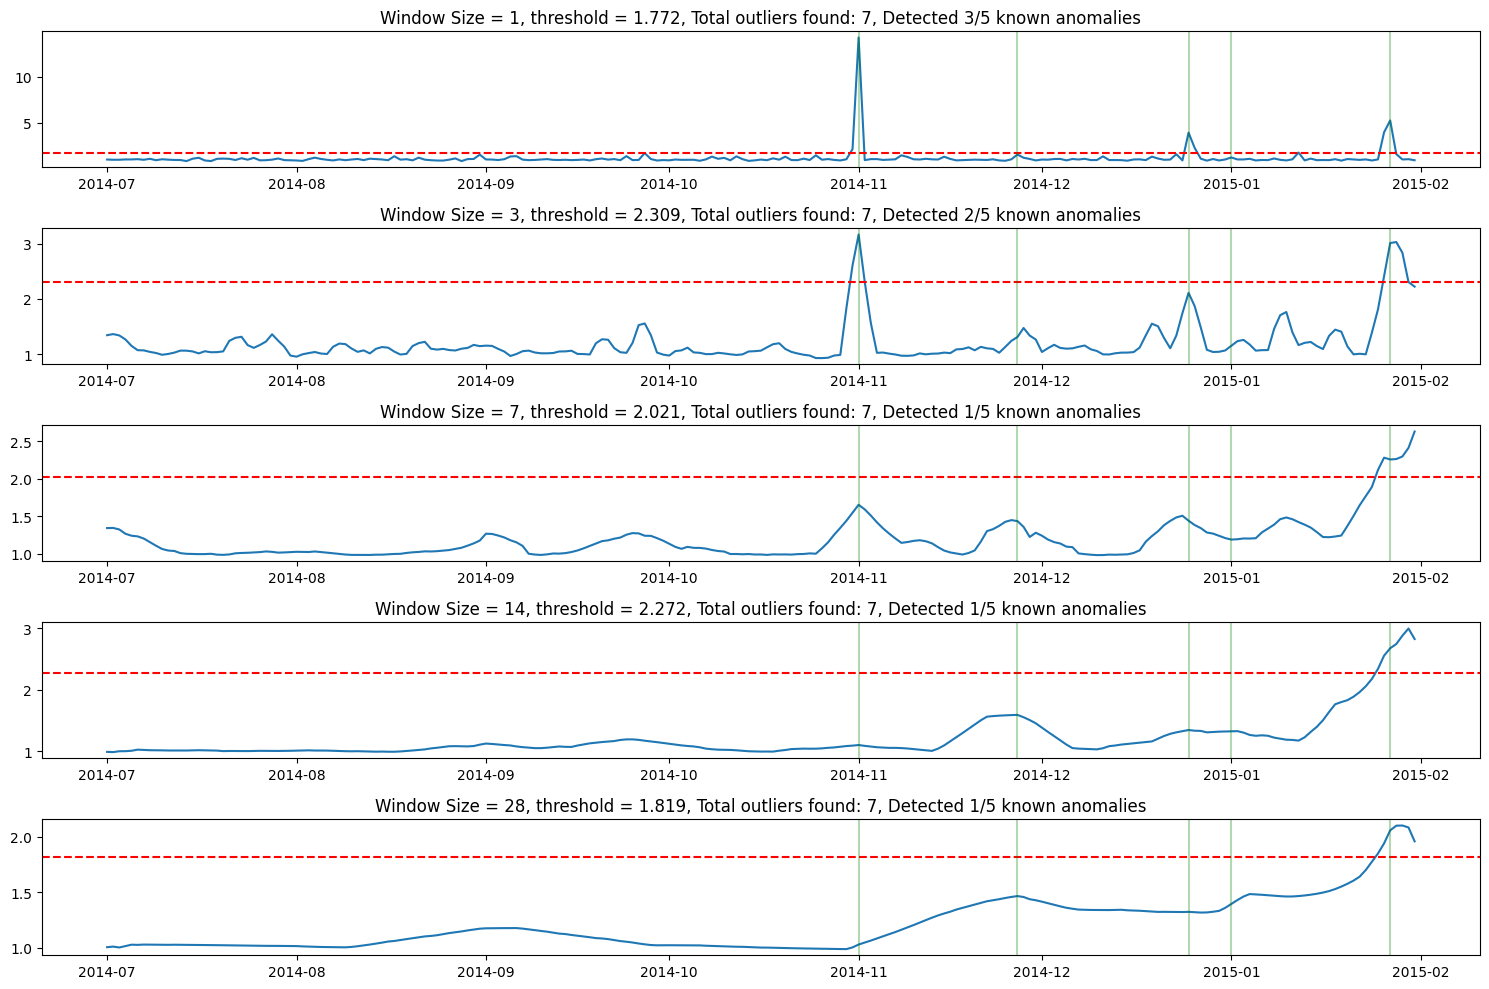

In [81]:
plt.figure(figsize=(15, 10))
known_anomalies = pd.to_datetime(nyc_dates)
window_sizes = [1, 3, 7, 14, 28]

for i, window in enumerate(window_sizes, 1):
    detector = PyODAdapter(
        pyod_model=LOF(contamination=0.03, n_neighbors=5),
        window_size=window
    )
    
    scores = pd.Series(detector.fit_predict(tx, axis=0), index=tx.index)
    threshold = scores.quantile(0.97)
    outliers = scores > threshold
    outlier_dates = scores[outliers].index
    
    # Check against known anomalies
    detected = sum(anomaly in outlier_dates for anomaly in known_anomalies)
    
    plt.subplot(len(window_sizes), 1, i)
    plt.plot(scores)
    plt.title(f"Window Size = {window}, threshold = {threshold:.3f}, Total outliers found: {sum(outliers)}, Detected {detected}/{len(known_anomalies)} known anomalies")
    plt.axhline(y=threshold, color='r', linestyle='--')
    
    # Mark known anomalies
    for date in nyc_dates:
        if pd.Timestamp(date) in scores.index:
            plt.axvline(x=pd.Timestamp(date), color='g', alpha=0.3)

plt.tight_layout()
plt.show()


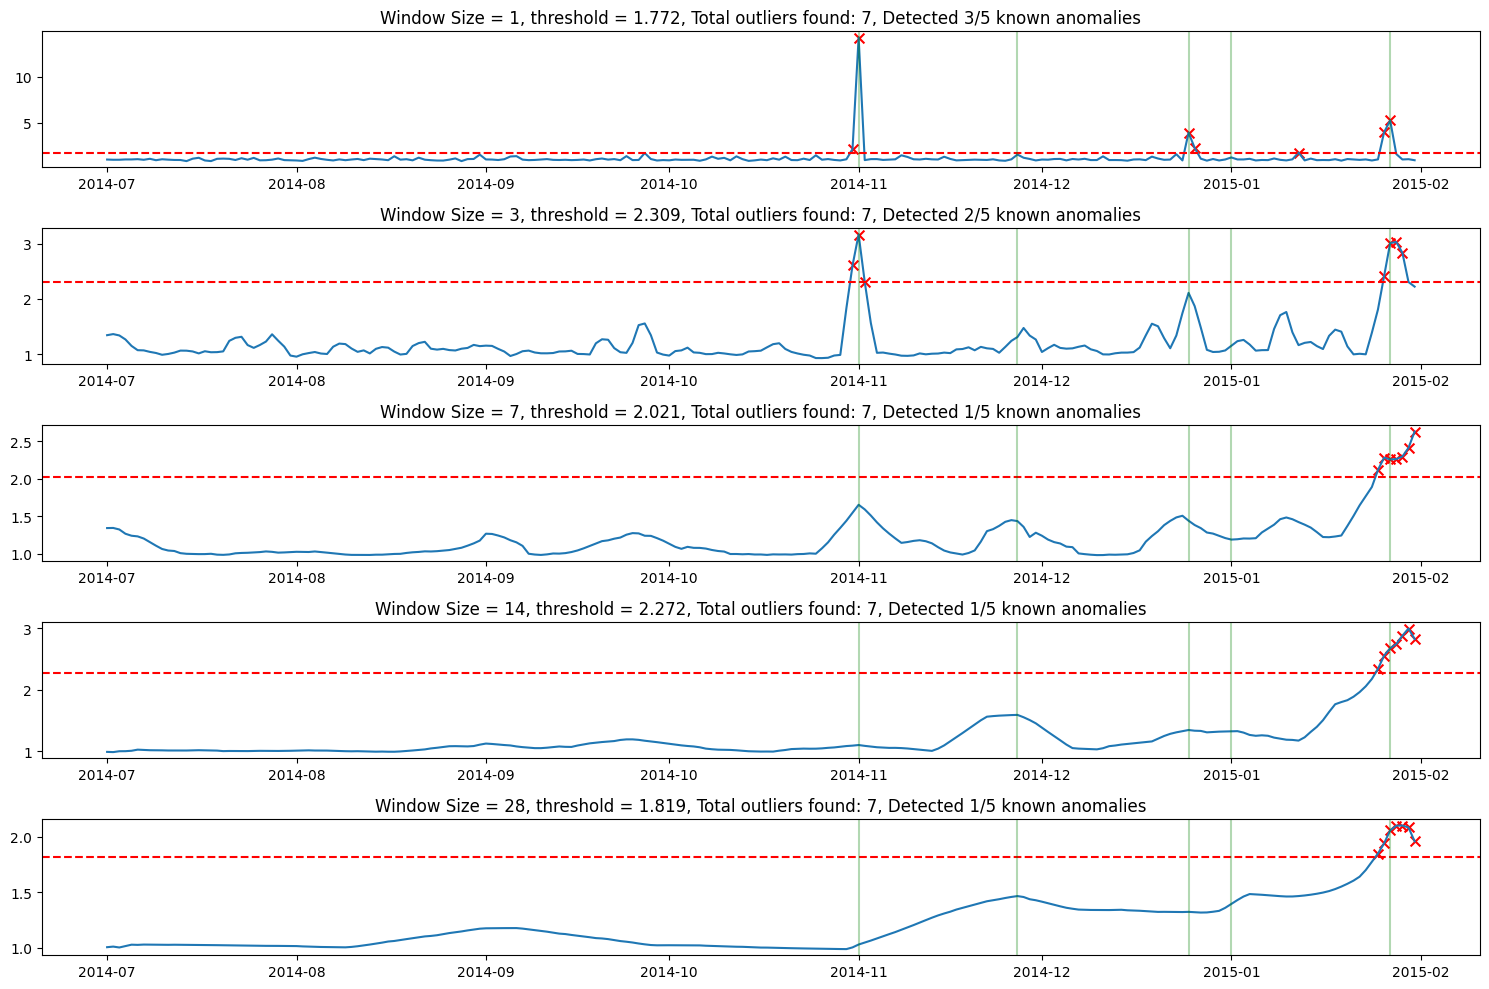

In [82]:
plt.figure(figsize=(15, 10))
known_anomalies = pd.to_datetime(nyc_dates)

for i, window in enumerate(window_sizes, 1):
    detector = PyODAdapter(
        pyod_model=LOF(contamination=0.03, n_neighbors=5),
        window_size=window
    )
    
    scores = pd.Series(detector.fit_predict(tx, axis=0), index=tx.index)
    threshold = scores.quantile(0.97)
    outliers = scores > threshold
    outlier_dates = scores[outliers].index
    
    # Check against known anomalies
    detected = sum(anomaly in outlier_dates for anomaly in known_anomalies)
    
    plt.subplot(len(window_sizes), 1, i)
    plt.plot(scores)
    
    # Mark outliers with X
    plt.scatter(outlier_dates, scores[outliers], color='red', marker='x', s=50)
    
    plt.title(f"Window Size = {window}, threshold = {threshold:.3f}, Total outliers found: {sum(outliers)}, Detected {detected}/{len(known_anomalies)} known anomalies")
    plt.axhline(y=threshold, color='r', linestyle='--')
    
    # Mark known anomalies
    for date in nyc_dates:
        if pd.Timestamp(date) in scores.index:
            plt.axvline(x=pd.Timestamp(date), color='g', alpha=0.3)
plt.tight_layout()
plt.show()


# Detecting outliers using clustering-based algorithms (PyOD)

In [83]:
from pyod.models.cblof import CBLOF

In [142]:
cblof = CBLOF(n_clusters=8, 
              contamination=0.03,
              alpha=0.9,
              random_state=15,
              beta=5)
cblof

,n_clusters,8
,contamination,0.03
,clustering_estimator,None
,alpha,0.9
,beta,5
,use_weights,False
,check_estimator,False
,random_state,15
,n_jobs,None


In [143]:
cblof.fit(tx)
cblof_pred = pd.Series(cblof.predict(tx), 
                      index=tx.index)
print('Number of CBLOF outliers = ', cblof_pred.sum())

Number of CBLOF outliers =  7


In [148]:
# extract the outlier values and dates from cblof_pred
cblof_outliers = cblof_pred[cblof_pred == 1]
cblof_outliers = tx.loc[cblof_outliers.index] 
print(cblof_outliers)


                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-11-28  12850.854167
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


In [149]:
print(known_outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667


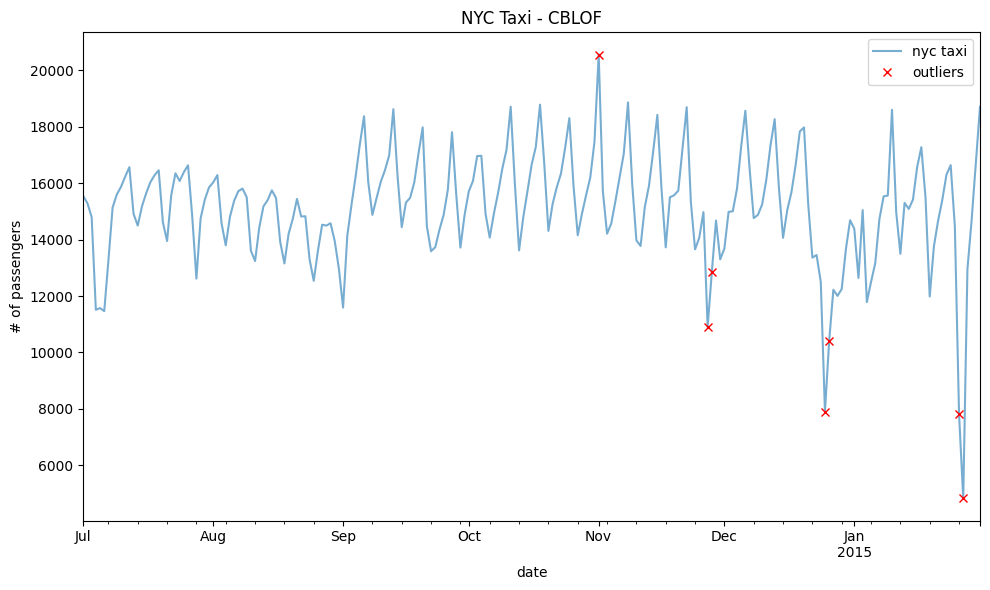

In [150]:
plot_outliers(cblof_outliers, tx, 'CBLOF')

In [151]:
from pyod.utils import evaluate_print
# Create binary ground truth labels (1 for known outliers, 0 for normal points)
y = tx.index.isin(known_outliers.index).astype(int)
evaluate_print('CBLOF', y, cblof.decision_scores_)

CBLOF ROC:0.9333, precision @ rank n:0.6


## There's more

In [152]:
from aeon.anomaly_detection.series.distance_based import KMeansAD

aeon_kmeans = KMeansAD(n_clusters=8, window_size=7)
aeon_pred = pd.Series(aeon_kmeans.fit_predict(tx, axis=0), 
                      index=tx.index)


In [153]:
threshold = aeon_pred.quantile(0.97)  
outliers_mask = aeon_pred > threshold
outliers = tx[outliers_mask]
print(outliers)

                   value
timestamp               
2015-01-25  14463.791667
2015-01-26   7818.979167
2015-01-27   4834.541667
2015-01-28  12947.562500
2015-01-29  14686.145833
2015-01-30  16676.625000
2015-01-31  18702.479167


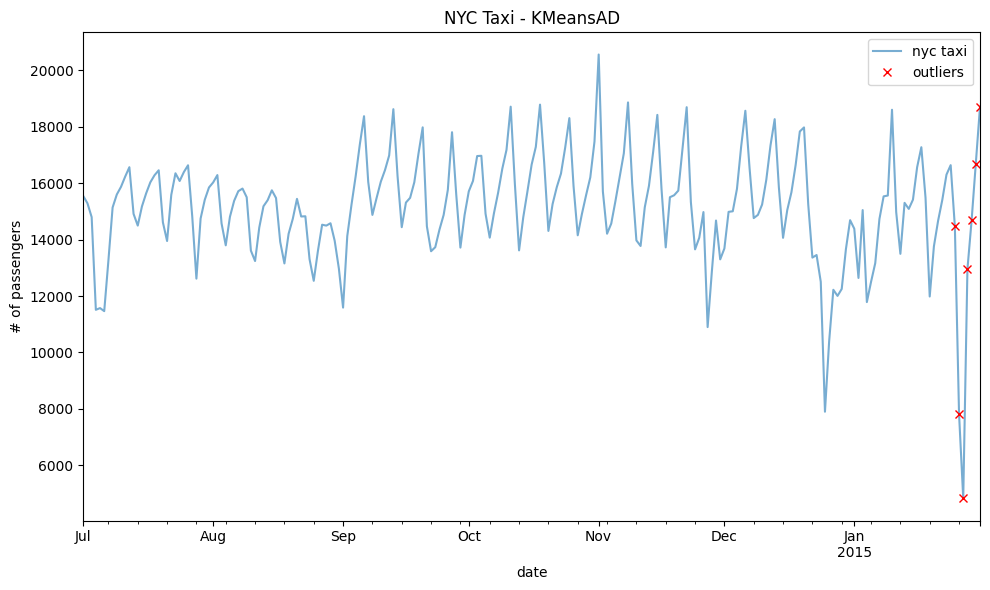

In [154]:
plot_outliers(outliers, tx, 'KMeansAD')

# Detecting outliers using probabilistic and statistical algorithms

In [155]:
from pyod.models.copod import COPOD

In [156]:
copod = COPOD(contamination=0.03)
copod.fit(tx)

,contamination,0.03
,n_jobs,1


In [157]:
copod_pred = pd.Series(copod.predict(tx), 
                      index=tx.index)

In [158]:
print('Number of COPOD outliers = ', copod_pred.sum())

Number of COPOD outliers =  7


In [159]:
# extract the outlier values and dates from copod_pred
copod_outliers = copod_pred[copod_pred == 1]
copod_outliers = tx.loc[copod_outliers.index]
print(copod_outliers)

                   value
timestamp               
2014-07-04  11511.770833
2014-07-06  11464.270833
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


In [160]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


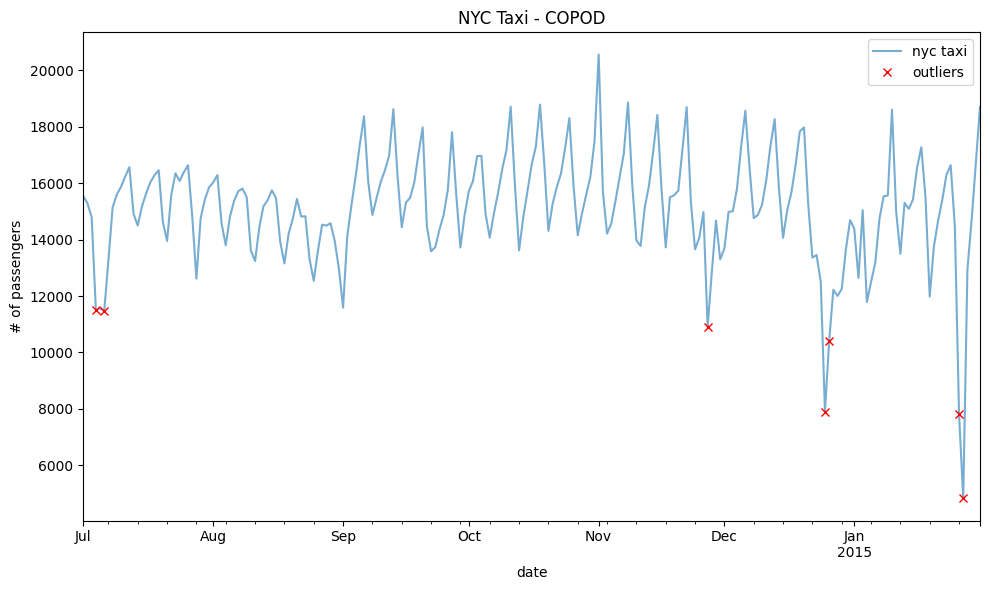

In [161]:
plot_outliers(copod_outliers, tx, 'COPOD')

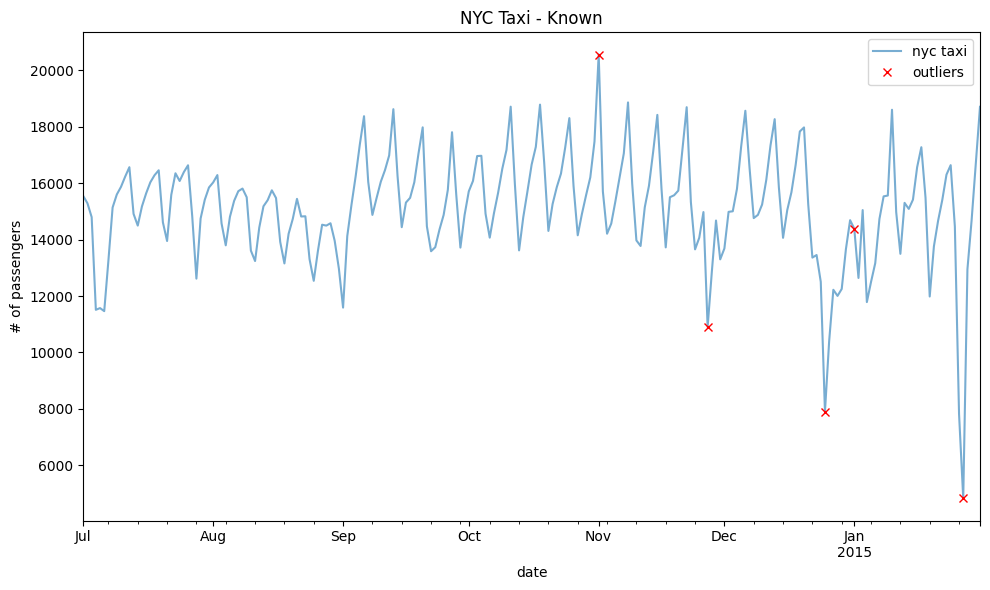

In [111]:
plot_outliers(known_outliers, tx, 'Known')

## There is more

In [162]:
from pyod.models.ecod import ECOD

# Initialize and fit the ECOD model
ecod = ECOD(contamination=0.03)
ecod.fit(tx)

# Predict outliers
ecod_pred = pd.Series(ecod.predict(tx), 
                     index=tx.index)
print('Number of ECOD outliers = ', ecod_pred.sum())

# extract the outlier values and dates from ecod_pred
ecod_outliers = ecod_pred[ecod_pred == 1]
ecod_outliers = tx.loc[ecod_outliers.index]
print(ecod_outliers)

Number of ECOD outliers =  6
                   value
timestamp               
2014-10-18  18778.958333
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-12-25   7902.125000
2015-01-26   7818.979167
2015-01-27   4834.541667


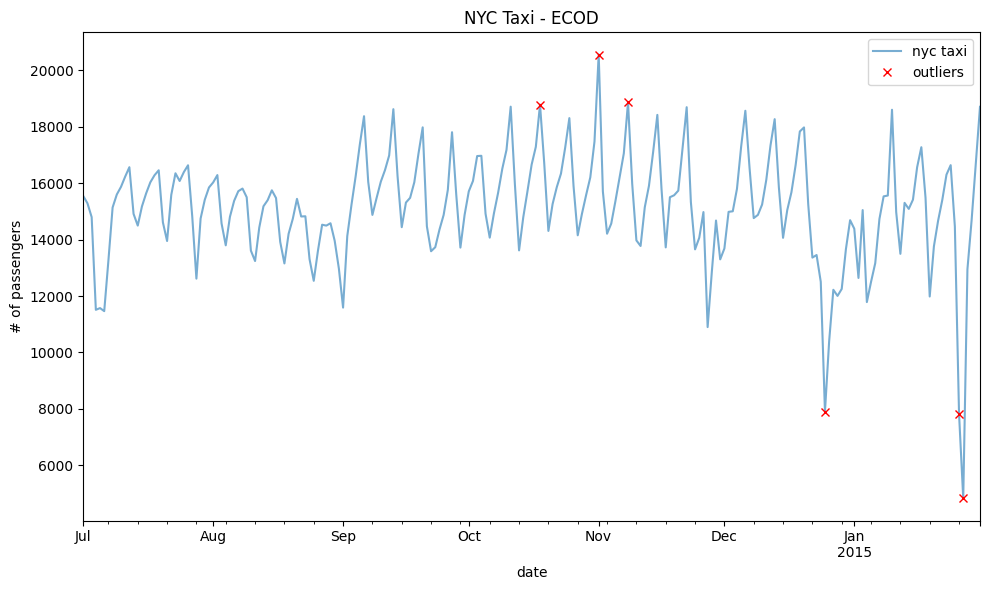

In [163]:
plot_outliers(ecod_outliers, tx, 'ECOD')

# Detecting outliers using kernel-based algorithms (PyOD)

In [164]:
from pyod.models.ocsvm import OCSVM

In [165]:
ocsvm = OCSVM(contamination=0.03, 
              kernel='rbf',
              gamma='auto',
              nu=0.5)
ocsvm.fit(tx)

,kernel,'rbf'
,degree,3
,gamma,'auto'
,coef0,0.0
,tol,0.001
,nu,0.5
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1
,contamination,0.03


In [166]:
ocsvm_pred = pd.Series(ocsvm.predict(tx), 
                      index=tx.index)

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch14/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


In [167]:
print('Number of OCSVM outliers = ', ocsvm_pred.sum())

Number of OCSVM outliers =  5


In [168]:
# extract the outlier values and dates from ocsvm_pred
ocsvm_outliers = ocsvm_pred[ocsvm_pred == 1]
ocsvm_outliers = tx.loc[ocsvm_outliers.index] 
print(ocsvm_outliers)

                   value
timestamp               
2014-08-09  15499.708333
2014-11-18  15499.437500
2014-11-27  10899.666667
2014-12-24  12502.000000
2015-01-05  12502.750000


In [169]:
print(known_outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667


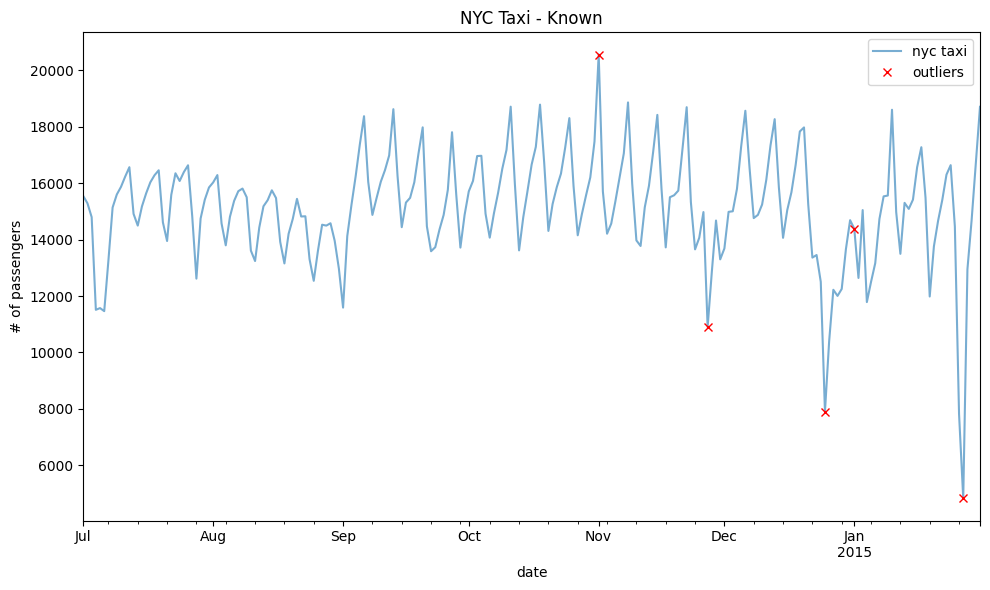

In [170]:
plot_outliers(known_outliers, tx, 'Known')

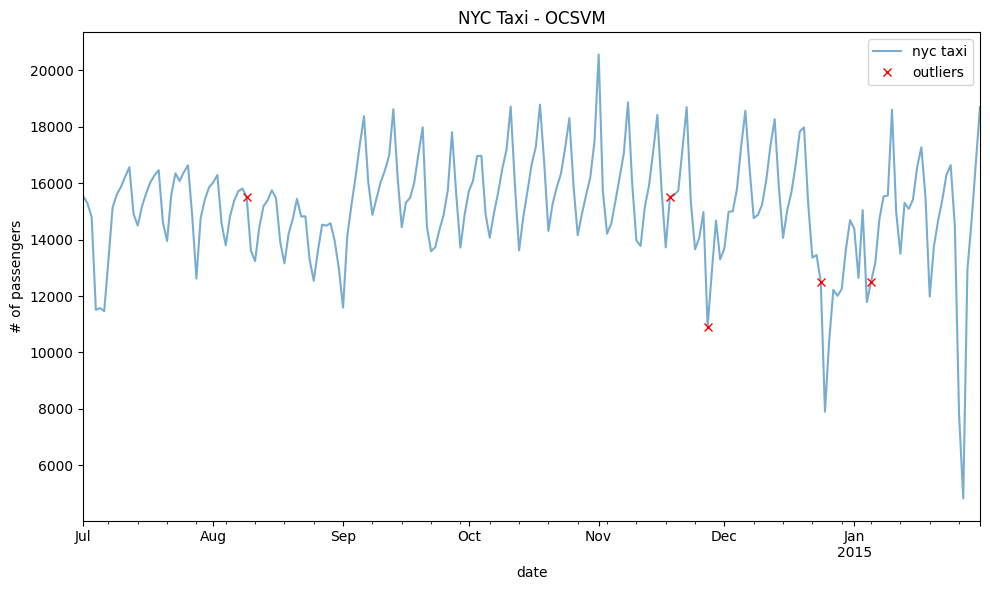

In [171]:
plot_outliers(ocsvm_outliers, tx, 'OCSVM')

In [172]:
from pyod.utils.utility import standardizer

ocsvm = OCSVM(contamination=0.03, 
              kernel='rbf',
              gamma='auto',
              nu=0.5)

scaled = standardizer(tx)
ocsvm.fit(scaled)
ocsvm_pred_sc = pd.Series(ocsvm.predict(scaled), 
                      index=tx.index)

# extract the outlier values and dates from ocsvm_pred_sc
ocsvm_outliers_sc = ocsvm_pred_sc[ocsvm_pred_sc == 1]
ocsvm_outliers_sc = tx.loc[ocsvm_outliers_sc.index] 
print(ocsvm_outliers_sc)

                   value
timestamp               
2014-07-06  11464.270833
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


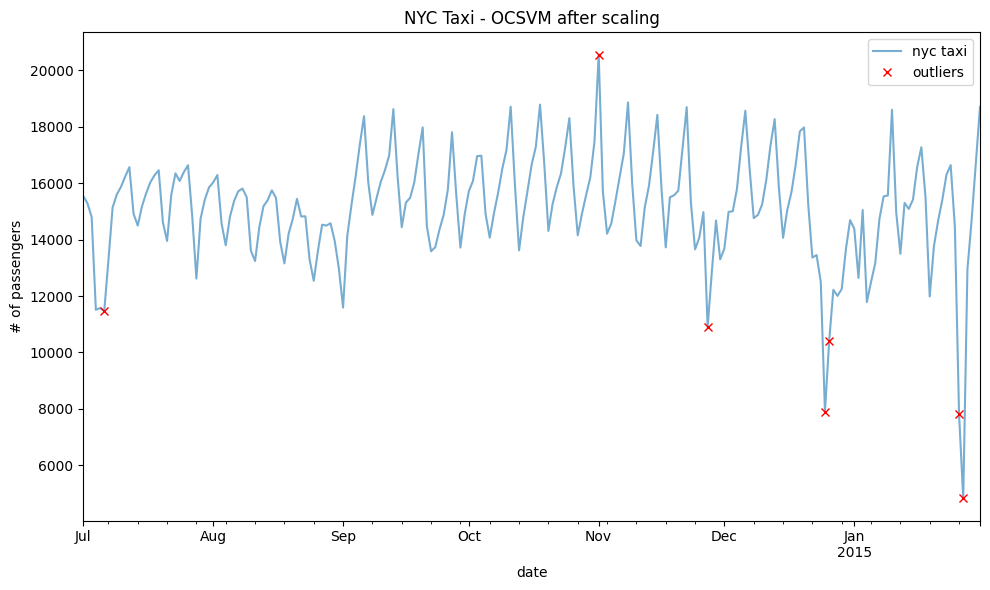

In [173]:
plot_outliers(ocsvm_outliers_sc, tx, 'OCSVM after scaling')

## There is more

In [174]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    ocsvm = OCSVM(contamination=0.03, 
                  kernel=kernel)
    ocsvm.fit(scaled)
    ocsvm_pred_sc = pd.Series(ocsvm.predict(scaled), 
                              index=tx.index, 
                              name=kernel)
    ocsvm_outliers_sc = ocsvm_pred_sc[ocsvm_pred_sc == 1]
    ocsvm_outliers_sc = tx.loc[ocsvm_outliers_sc.index]
    print(f"Outliers using {kernel} kerenl: \n{ocsvm_outliers_sc}")
    #plot_outliers(ocsvm_outliers_sc, tx, f"OCSVM using {kernel} kernel")

Outliers using linear kerenl: 
                   value
timestamp               
2014-09-13  18617.729167
2014-10-11  18706.416667
2014-10-18  18778.958333
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-22  18688.062500
2015-01-31  18702.479167
Outliers using poly kerenl: 
                   value
timestamp               
2014-07-04  11511.770833
2014-07-06  11464.270833
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
Outliers using rbf kerenl: 
                   value
timestamp               
2014-07-06  11464.270833
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
Outliers using sigmoid kerenl: 
                   value
timestamp               
2014-07-04  11511.770833
2014-07-06  11464.270833
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-

# Detecting outliers using ensemble methods algorithms (PyOD)

In [175]:
from pyod.models.iforest import IForest

In [176]:
iforest = IForest(contamination=0.03,
                 n_estimators=100,
                 bootstrap=False,
                 random_state=45)
iforest.fit(tx)

,n_estimators,100
,max_samples,'auto'
,contamination,0.03
,max_features,1.0
,bootstrap,False
,n_jobs,1
,behaviour,'old'
,random_state,45
,verbose,0


In [178]:
iforest_pred = pd.Series(iforest.predict(tx), 
                      index=tx.index)

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch14/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [179]:
print('Number of IForest outliers = ', iforest_pred.sum())

Number of IForest outliers =  7


In [180]:
# extract the outlier values and dates from iforest_pred
iforest_outliers = iforest_pred[iforest_pred == 1]
iforest_outliers = tx.loc[iforest_outliers.index] 
print(iforest_outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


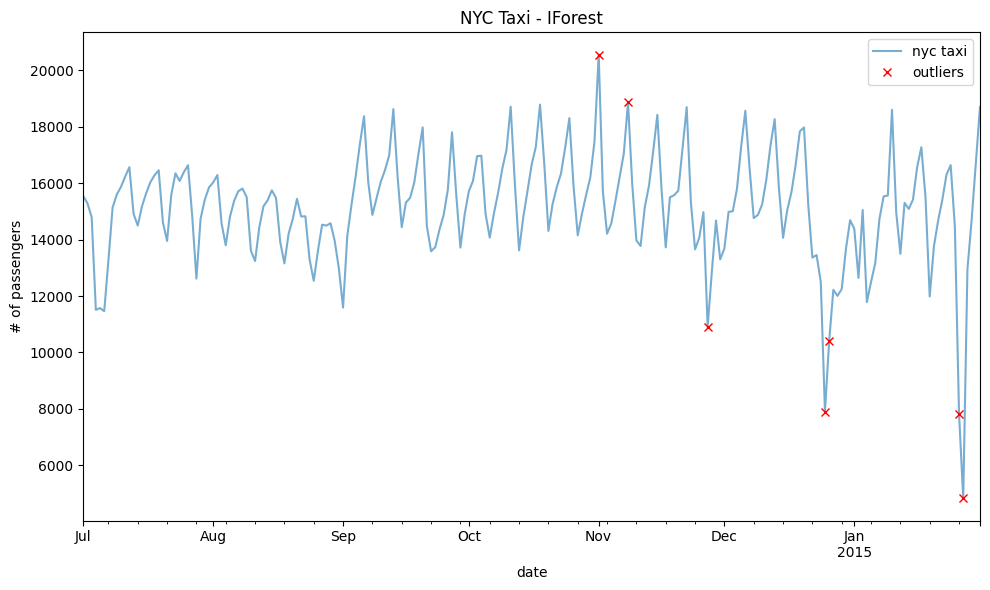

In [181]:
plot_outliers(iforest_outliers, tx, 'IForest')

## There is more

In [183]:
import pandas as pd
from pyod.models.dif import DIF
import warnings
warnings.filterwarnings('ignore')

# Initialize and fit the DIF model 
dif = DIF(contamination=0.03, 
          n_estimators=100, 
          random_state=42)
dif.fit(tx)

# Get outliers
dif_scores = dif.decision_scores_
dif_threshold = np.quantile(dif_scores, 0.97)  # Adjust percentile as needed
dif_outliers = tx[dif_scores > dif_threshold]
print(dif_outliers)

                   value
timestamp               
2014-09-13  18617.729167
2014-10-11  18706.416667
2014-10-18  18778.958333
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-22  18688.062500
2015-01-31  18702.479167


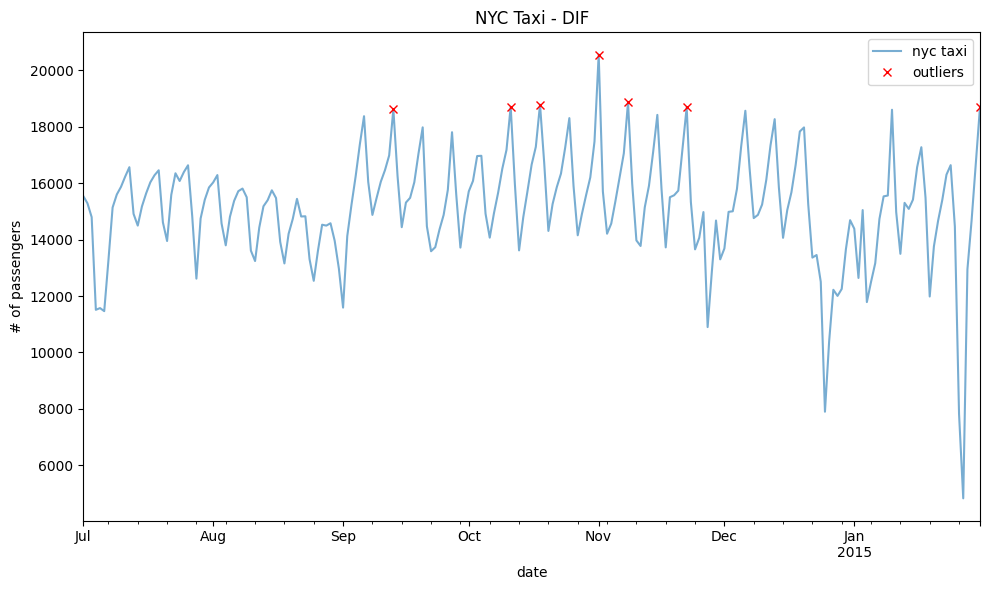

In [31]:
plot_outliers(dif_outliers, tx, 'DIF')

# Detecting outliers using deep learning-based algorithms (PyOD)

In [278]:
# !pip install torch
# !pip install tqdm

In [184]:
from pyod.models.auto_encoder import AutoEncoder

In [185]:
# lr: Learning rate for optimization
# epoch_num: Number of training iterations
# batch_size: Number of samples per training batch
auto_encoder = AutoEncoder(contamination=0.03,
                           lr=0.001,
                           epoch_num=10,
                           batch_size=32)
auto_encoder.fit(tx)

Training: 100%|██████████| 10/10 [00:00<00:00, 59.94it/s]


In [186]:
ae_predicted = pd.Series(auto_encoder.predict(tx), 
                      index=tx.index)

In [187]:
print('Number of AutoEncoder outliers = ', ae_predicted.sum())

Number of AutoEncoder outliers =  7


In [188]:
# extract the outlier values and dates from ae_predicted
ae_outliers = ae_predicted[ae_predicted == 1]
ae_outliers = tx.loc[ae_outliers.index] 
print(ae_outliers)

                   value
timestamp               
2014-09-23  13729.354167
2014-09-29  13715.166667
2014-11-17  13722.791667
2014-11-24  13652.625000
2014-12-01  13683.625000
2014-12-30  13659.687500
2015-01-20  13759.416667


In [189]:
ae_scores = pd.Series(auto_encoder.decision_scores_, 
                      index=tx.index)

threshold = auto_encoder.threshold_
# or you can do it using quantile 
threshold = ae_scores.quantile(0.97)

In [190]:
ae_outliers =tx[ae_scores > ae_scores.quantile(0.97)]
print(ae_outliers)

                   value
timestamp               
2014-09-23  13729.354167
2014-09-29  13715.166667
2014-11-17  13722.791667
2014-11-24  13652.625000
2014-12-01  13683.625000
2014-12-30  13659.687500
2015-01-20  13759.416667


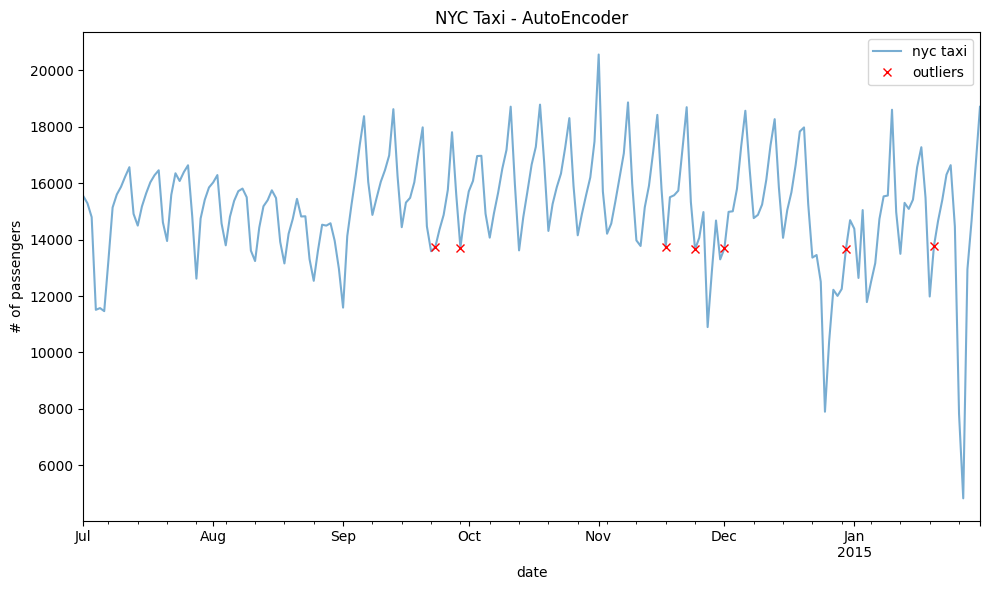

In [191]:
plot_outliers(ae_outliers, tx, 'AutoEncoder')

In [192]:
%%time
auto_encoder = AutoEncoder(contamination=0.03,
                           lr=0.001,
                           epoch_num=1000,
                           batch_size=32)
auto_encoder.fit(tx)
ae_predicted = pd.Series(auto_encoder.predict(tx), 
                      index=tx.index)
# extract the outlier values and dates from ae_predicted
ae_outliers = ae_predicted[ae_predicted == 1]
ae_outliers = tx.loc[ae_outliers.index] 
print(ae_outliers)

Training: 100%|██████████| 1000/1000 [00:13<00:00, 74.64it/s]

                   value
timestamp               
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
CPU times: user 9.51 s, sys: 11.2 s, total: 20.7 s
Wall time: 13.4 s


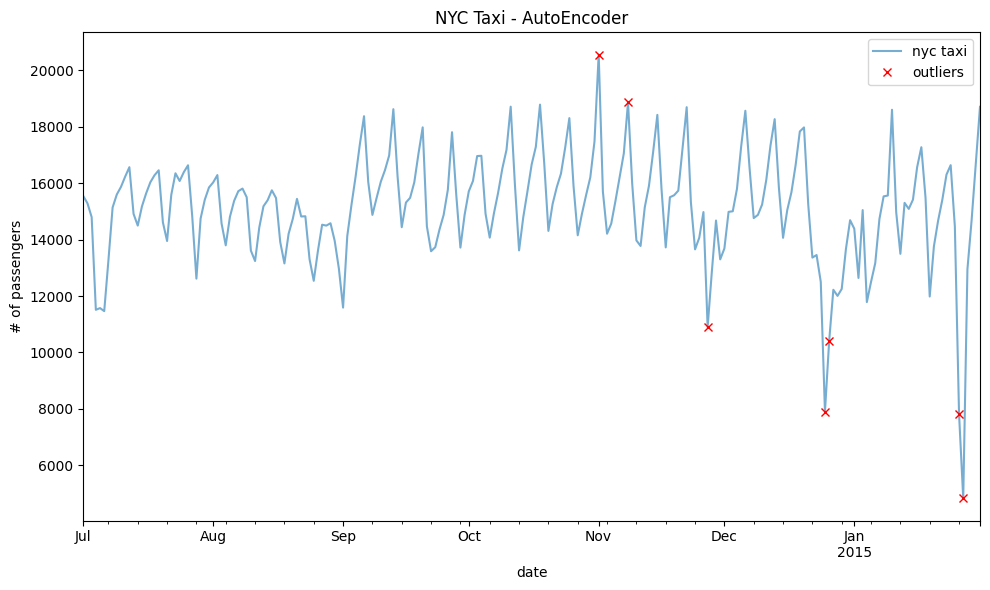

In [193]:
plot_outliers(ae_outliers, tx, 'AutoEncoder')

In [195]:
from pyod.models.suod import SUOD

# assuming these classes are already imported from prior recipes
knn = KNN(method='mean', n_neighbors=5)
lof = LOF(n_neighbors=20)

cblof = CBLOF(n_clusters=8, alpha=0.9, beta=5)
copod = COPOD()
ocsvm = OCSVM(kernel='rbf', gamma='auto', nu=0.5)
iforest = IForest(n_estimators=100, random_state=45)

# initialized a group of outlier detectors for acceleration
detector_list = [knn, lof, cblof, copod, ocsvm, iforest]
clf = SUOD(contamination=0.03,
           base_estimators=detector_list, # List of models to combine
           n_jobs=2, # Number of parallel jobs
           combination='average', # How to combine model predictions
           verbose=True)

clf.fit(tx)
# Predict outliers
clf_pred = pd.Series(clf.predict(tx),
                     index=tx.index)

print('Number of SUOD outliers = ', clf_pred.sum())
# extract the outlier values and dates from clf_pred
clf_outliers = clf_pred[clf_pred == 1]
clf_outliers = tx.loc[clf_outliers.index]
print(clf_outliers)

RandomForestRegressor()
Worker 1 sum of ranks: 6.0
Worker 2 sum of ranks: 3.5

Split among workers BPS: [0, 4, 6] [4, 2]
Parallel Training...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished


Balanced Scheduling Total Train Time: 2.3535590171813965
Split among workers default: [3 6] [np.int64(3)]
Worker 1 sum of ranks: 6.166666666666666
Worker 2 sum of ranks: 3.333333333333333

Split among workers BPS: [0, 4, 6] [4, 2]
Parallel score prediction...
Parallel Score Prediction without Approximators Total Time: 0.044660091400146484
Number of SUOD outliers =  7
                   value
timestamp               
2014-07-06  11464.270833
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


## There is more

In [158]:
from pyod.models.vae import VAE

# lr: Learning rate for optimization
# epoch_num: Number of training iterations
# batch_size: Number of samples per training batch
vae = VAE(contamination=0.03,
                           lr=0.001,
                           epoch_num=1000,
                           batch_size=32)
vae.fit(tx)

vae_predicted = pd.Series(vae.predict(tx), 
                      index=tx.index)
# extract the outlier values and dates from ae_predicted
vae_outliers = vae_predicted[vae_predicted == 1]
vae_outliers = tx.loc[vae_outliers.index] 
print(vae_outliers)

Training: 100%|██████████| 1000/1000 [00:10<00:00, 98.50it/s]


                   value
timestamp               
2014-07-04  11511.770833
2014-07-06  11464.270833
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
